In [ ]:
!pip install yfinance


In [ ]:
import yfinance as yf

# Download historical data for S&P 500 (symbol: ^GSPC)
sp500_data = yf.download('^GSPC', start='2000-01-01', end='2024-01-01')

# Display the first few rows
print(sp500_data.head())


[*********************100%***********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971  1455.219971   
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1399.420044   
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1402.109985   
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1403.449951   
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1441.469971   

                Volume  
Date                    
2000-01-03   931800000  
2000-01-04  1009000000  
2000-01-05  1085500000  
2000-01-06  1092300000  
2000-01-07  1225200000  


In [ ]:
sp500_data.to_csv('sp500_data.csv')


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout
import matplotlib.pyplot as plt



sp500_data = yf.download('^GSPC', start='2000-01-01', end='2024-01-01')

# Use multiple features: Open, High, Low, Close, Volume
features = sp500_data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)


def create_windowed_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size][3])  # Predict the 'Close' price
    return np.array(X), np.array(y)

window_size = 50

# Create windowed data
X, y = create_windowed_data(features_scaled, window_size)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

model = Sequential()

# 1D CNN layers for pattern extraction
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layers for sequence learning
model.add(LSTM(units=100, return_sequences=False))

# Fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))  # Regularization to prevent overfitting
model.add(Dense(1))  # Output layer (predict Close price)

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

predicted_stock_price = model.predict(X_test)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 48, 64)              │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 22, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 11, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,429 (478.24 KB)

 Trainable params: 122,429 (478.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.0194 - val_loss: 0.0027
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0043 - val_loss: 4.7628e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0034 - val_loss: 2.7807e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0031 - val_loss: 4.0157e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0029 - val_loss: 4.3061e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0028 - val_loss: 5.6710e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0026 - val_loss: 4.3957e-04
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0022 - val_loss: 3.5373e-04
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0021 - val_loss: 3.7500e-04
Epoch 10/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0024 - val_loss: 3.5379e-04
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0022 - val_loss: 

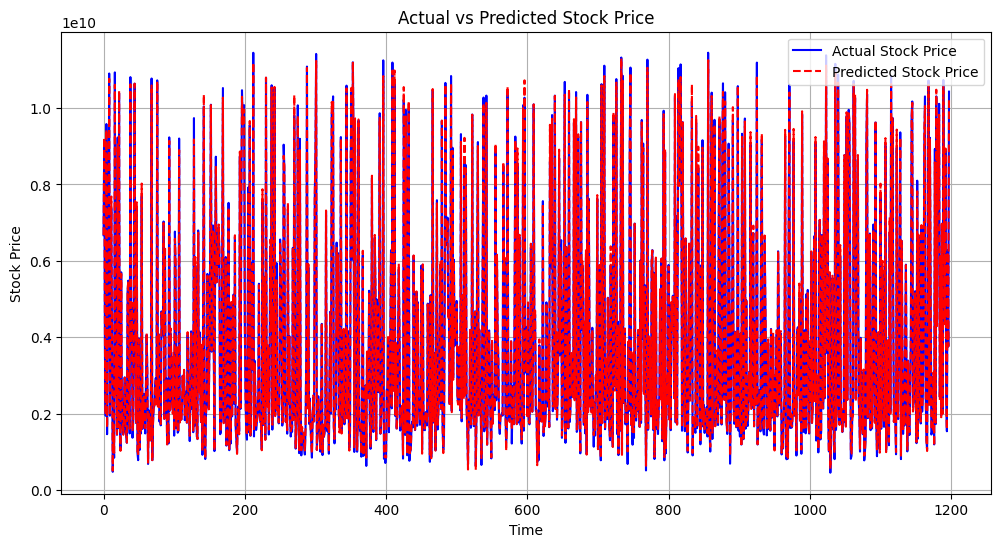

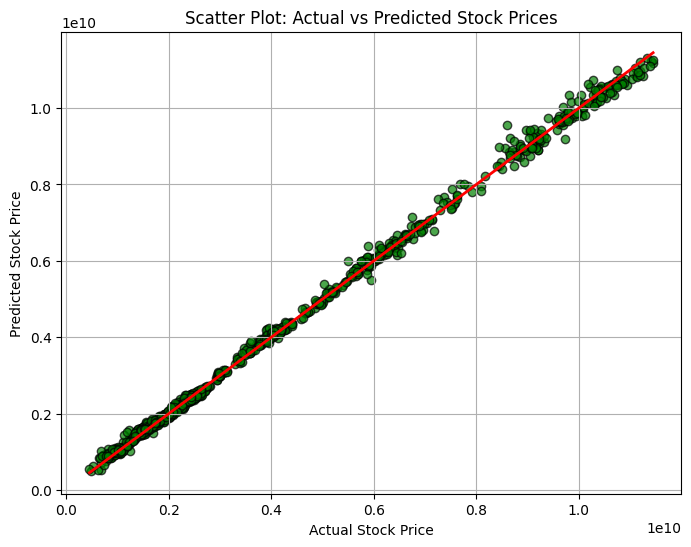

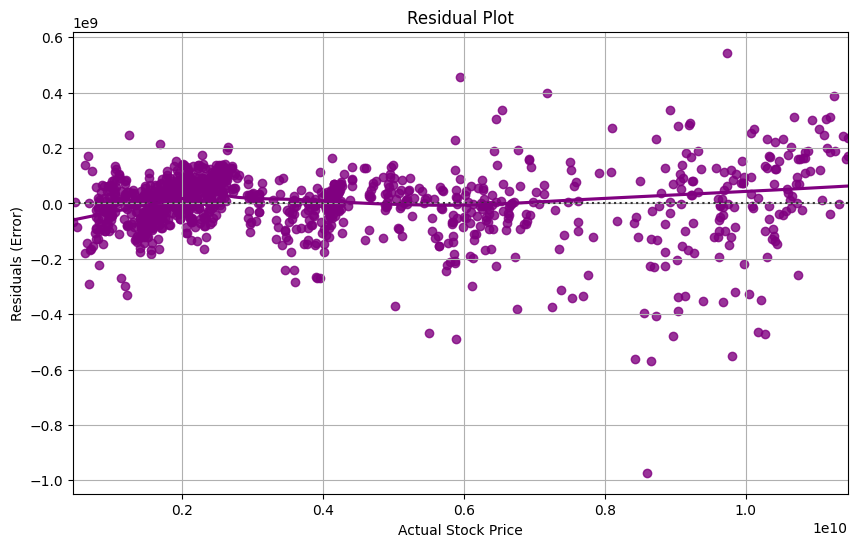

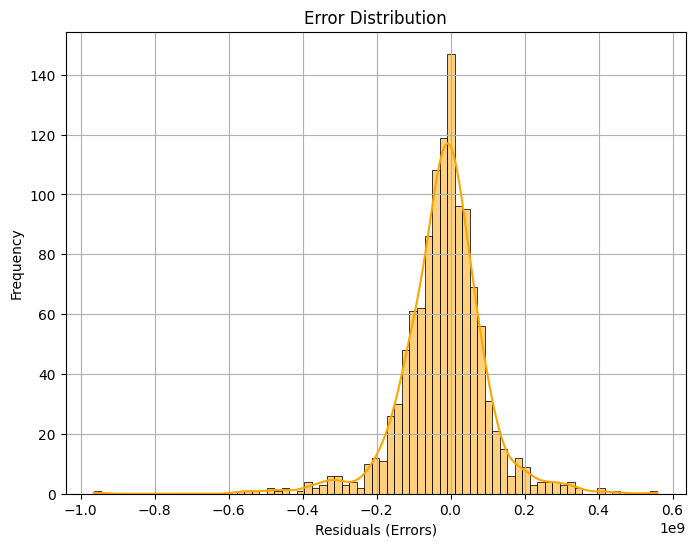

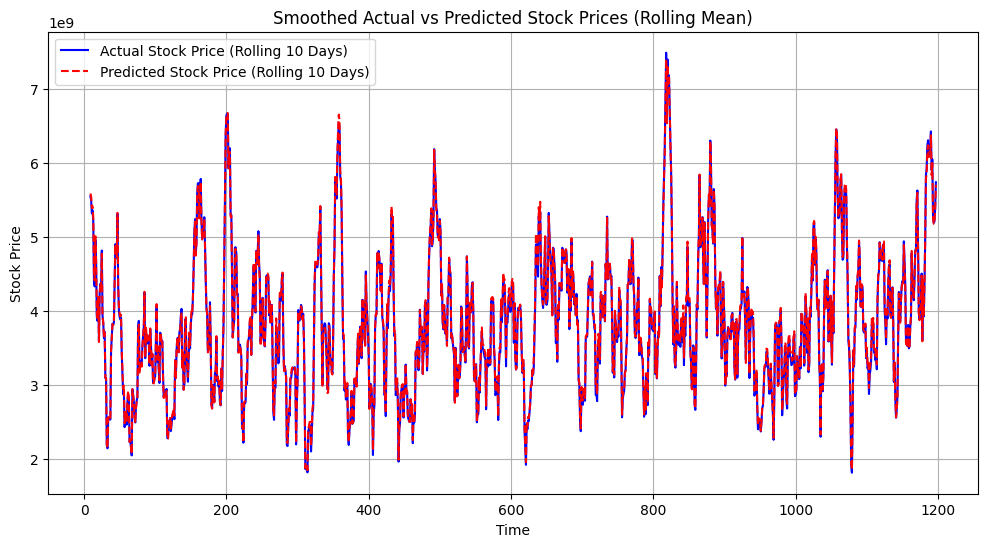

Root Mean Squared Error (RMSE): 117468621.1067
Mean Absolute Error (MAE): 79671825.7352


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.graph_objects as go

# Calculate the residuals (errors)
residuals = actual_stock_price - predicted_stock_price

# Line Plot: Actual vs Predicted Stock Prices
plt.figure(figsize=(12, 6))
plt.plot(actual_stock_price, label='Actual Stock Price', color='blue')
plt.plot(predicted_stock_price, label='Predicted Stock Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(actual_stock_price, predicted_stock_price, c='green', edgecolor='k', alpha=0.7)
plt.title('Scatter Plot: Actual vs Predicted Stock Prices')
plt.xlabel('Actual Stock Price')
plt.ylabel('Predicted Stock Price')
plt.grid(True)
plt.plot([min(actual_stock_price), max(actual_stock_price)], [min(actual_stock_price), max(actual_stock_price)], color='red', lw=2)
plt.show()

# Residual Plot: Residuals (Errors)
plt.figure(figsize=(10, 6))
sns.residplot(x=actual_stock_price, y=residuals, lowess=True, color='purple')
plt.title('Residual Plot')
plt.xlabel('Actual Stock Price')
plt.ylabel('Residuals (Error)')
plt.grid(True)
plt.show()

# Histogram: Error Distribution (Residuals)
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='orange')
plt.title('Error Distribution')
plt.xlabel('Residuals (Errors)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Line Plot with Rolling Mean (Smoothing)
window_size = 10
actual_rolling = pd.Series(actual_stock_price).rolling(window=window_size).mean()
predicted_rolling = pd.Series(predicted_stock_price).rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(actual_rolling, label=f'Actual Stock Price (Rolling {window_size} Days)', color='blue')
plt.plot(predicted_rolling, label=f'Predicted Stock Price (Rolling {window_size} Days)', color='red', linestyle='--')
plt.title('Smoothed Actual vs Predicted Stock Prices (Rolling Mean)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Candlestick Chart
candlestick_data = sp500_data.reset_index()

fig = go.Figure(data=[go.Candlestick(x=candlestick_data['Date'],
                                     open=candlestick_data['Open'],
                                     high=candlestick_data['High'],
                                     low=candlestick_data['Low'],
                                     close=candlestick_data['Close'])])

fig.update_layout(title='S&P 500 Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible=False)
fig.show()

# Metrics: RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price))
mae = mean_absolute_error(actual_stock_price, predicted_stock_price)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(actual_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_stock_price, predicted_stock_price)
r2 = r2_score(actual_stock_price, predicted_stock_price)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 13798876944708630.0000
Root Mean Squared Error (RMSE): 117468621.1067
Mean Absolute Error (MAE): 79671825.7352
R-squared (R2): 0.9984


In [10]:
model.save('my_model.keras')

In [6]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 21.0 MB/s eta 0:00:00


In [7]:
print("Shape of X_train:", X_train.shape)


Shape of X_train: (4789, 50, 5)


Permutation explainer: 201it [00:44,  3.72it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Original SHAP Values Shape: (200, 5)
Flattened SHAP Values Shape: (200, 5)
Original Feature Set Shape: (200, 5)


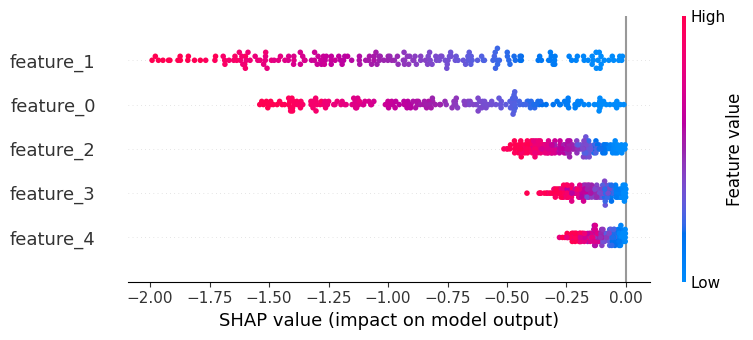

In [16]:
import numpy as np
import shap


def custom_masker(mask, x):
    """Masks the input data based on the provided mask.

    Args:
        mask (np.ndarray): Boolean array indicating which features to mask.
        x (np.ndarray): Input data to be masked.

    Returns:
        np.ndarray: Masked input data.
    """
    masked_x = x.copy()  # Create a copy of the input data

    # Ensure x is always 2D
    if x.ndim == 1:
        masked_x = masked_x.reshape(1, -1)

    masked_x[:, mask] = 0  # Mask the relevant columns

    return masked_x

# Calculate SHAP values
# 2. Pass the custom masker to the Explainer
explainer = shap.Explainer(model, masker=custom_masker)
shap_values = explainer(X_test)

print("Original SHAP Values Shape:", shap_values.shape)

shap_values_flattened = shap_values.values.reshape(shap_values.values.shape[0], -1)  # Reshape to (num_samples, num_features)

print("Flattened SHAP Values Shape:", shap_values_flattened.shape)

X_test_np = X_test.to_numpy()

print("Original Feature Set Shape:", X_test_np.shape)

# Ensure that the number of features matches
assert shap_values_flattened.shape[1] == X_test_np.shape[1], "The number of features does not match!"

# plot the SHAP summary
shap.summary_plot(shap_values_flattened, X_test_np, feature_names=X_test.columns) # Use original X_test